In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
%reload_ext autoreload
%autoreload 2

In [14]:
namesngenre = np.load('./dataset/namesngenre.npy')

In [15]:
namesngenre

array([['Toy Story (1995)',
        'Adventure|Animation|Children|Comedy|Fantasy'],
       ['Jumanji (1995)', 'Adventure|Children|Fantasy'],
       ['Grumpier Old Men (1995)', 'Comedy|Romance'],
       ...,
       ['Elsa & Fred (2005)', 'Comedy|Drama|Romance'],
       ['Tomb Raider (2018)', 'Action|Adventure|Fantasy'],
       ['Fred Armisen: Standup for Drummers (2018)', 'Comedy']],
      dtype='<U158')

In [16]:
ratings_train = np.load('./dataset/ratings_train.npy')

In [17]:
ratings_train.shape

(610, 4980)

In [18]:
ratings_train

array([[ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan,  2., nan, ..., nan, nan, nan],
       [ 3., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [19]:
np.nanmax(ratings_train)


5.0

In [20]:
np.nanmin(ratings_train)

0.5

# Matrix Factorization

In [21]:
import MF

In [22]:
k = 1

factorization = MF.MF(ratings_train, l=0.01, mu=0.01, k=k)


In [23]:
non_nan_indices = np.where(~np.isnan(ratings_train))
print(non_nan_indices)
# Separate the row and column indices
row_indices, col_indices = non_nan_indices
R_non_nan = factorization.R[row_indices, col_indices]

(array([  0,   0,   0, ..., 609, 609, 609], dtype=int64), array([   0,   44,   58, ..., 4928, 4929, 4937], dtype=int64))


In [24]:
factorization.fit(lr_I=0.0001, lr_U=0.0001, num_iterations=100)
prediction_full = factorization.predict()
prediction = prediction_full[row_indices, col_indices]
print(prediction)
factorization.RMSE_(prediction_full)

Iteration 1: Cost = 32392.999775727294. RMSE = 1.0094178556936002
Iteration 2: Cost = 31379.13921235615. RMSE = 0.9933969755194786
Iteration 3: Cost = 30618.05845467384. RMSE = 0.9811983620094424
Iteration 4: Cost = 30009.30220732772. RMSE = 0.9713307438572282
Iteration 5: Cost = 29502.756415628777. RMSE = 0.9630426867605009
Iteration 6: Cost = 29070.13009088203. RMSE = 0.9559070809645166
Iteration 7: Cost = 28693.74438039374. RMSE = 0.9496553845545416
Iteration 8: Cost = 28361.6839916821. RMSE = 0.9441054790234434
Iteration 9: Cost = 28065.46999072267. RMSE = 0.9391269580102453
Iteration 10: Cost = 27798.824657134937. RMSE = 0.934622676738243
Iteration 11: Cost = 27556.95734882301. RMSE = 0.9305180618239591
Iteration 12: Cost = 27336.123155609286. RMSE = 0.9267544853716159
Iteration 13: Cost = 27133.336150502648. RMSE = 0.9232849455999945
Iteration 14: Cost = 26946.175841176915. RMSE = 0.9200711413645253
Iteration 15: Cost = 26772.652478989065. RMSE = 0.917081429536286
Iteration 16: C

0.8384281041625187

0.8998834238908144


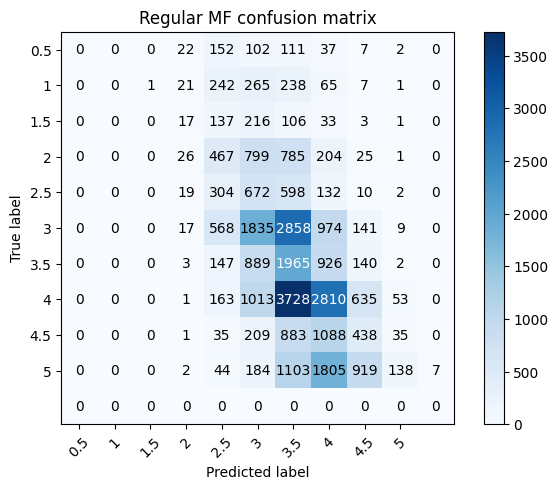

Accuracy: 23.79%


In [25]:
targets = np.load('./dataset/ratings_test.npy')
targets[np.isnan(targets)] = 0

predictions = np.round(prediction_full * 2)/2
rmse_value = RMSE(targets, predictions) 

print(rmse_value)
plot_cm(targets, predictions, title='Regular MF confusion matrix')
# Calculate the accuracy
correct_predictions = np.sum(targets[targets!=0] == predictions[targets!=0])
total_predictions = len(targets[targets!=0])

accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy * 100:.2f}%")

# Deep Matrix Factorization


In [3]:
import deepMF
import torch
import torch.nn as nn
import torch.optim as optim
%reload_ext autoreload
%autoreload 2

In [27]:
# Load the input data from a numpy file
ratings_train = np.load('dataset/ratings_train.npy')
ratings_test = np.load('dataset/ratings_test.npy')
# Replace NaN values with 0
ratings_train[np.isnan(ratings_train)] = 0
ratings_test[np.isnan(ratings_test)] = 0

In [28]:
total_data = ratings_train + ratings_test

non_empty_indices = np.where(total_data != 0)
non_empty_indices = np.array([non_empty_indices[0], non_empty_indices[1]])

indices = np.random.choice(np.array(range(non_empty_indices.shape[1])), size=non_empty_indices.shape[1], replace = False)

train_set_indices = indices[0:int(non_empty_indices.shape[1]*0.7)]
train_set_indices2d = np.array(non_empty_indices[:, train_set_indices])
train_set = np.zeros(total_data.shape)
train_set[train_set_indices2d[0], train_set_indices2d[1]] = total_data[train_set_indices2d[0], train_set_indices2d[1]]

test_set_indices = indices[int(non_empty_indices.shape[1]*0.7):]
test_set_indices2d = np.array(non_empty_indices[:, test_set_indices])
test_set = np.zeros(total_data.shape)
test_set[test_set_indices2d[0], test_set_indices2d[1]] = total_data[test_set_indices2d[0], test_set_indices2d[1]]

normalized_train_data = train_set/np.max(train_set)

normalized_test_data = test_set/np.max(test_set)

In [29]:
# Hyperparameters evaluation
encoded_dim = 32
input_size = normalized_train_data.shape 
hidden_size_row = 16
hidden_size_col = 64

In [30]:
import time

In [11]:
# Start the timer
start_time = time.time()
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
deepMF.train_model(model, optimizer, torch.FloatTensor(normalized_train_data), test_data=test_set)
# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time} seconds")

NameError: name 'time' is not defined

[3.488349676132202, 3.2830588817596436, 2.9497618675231934, 2.5483715534210205, 2.1814980506896973, 1.87100350856781, 1.6204049587249756, 1.4298213720321655, 1.290891408920288, 1.1935032606124878, 1.1262731552124023, 1.0803717374801636, 1.0501822233200073, 1.032271146774292, 1.0238873958587646, 1.0224112272262573, 1.024417519569397, 1.0270849466323853, 1.0288344621658325, 1.0294898748397827, 1.029266357421875, 1.0285323858261108, 1.0274219512939453, 1.0261353254318237, 1.0246378183364868, 1.0229134559631348, 1.0210301876068115, 1.019029140472412, 1.0169295072555542, 1.0147327184677124, 1.0123581886291504, 1.0098339319229126, 1.0072031021118164, 1.0044509172439575, 1.0016849040985107, 0.9988659620285034, 0.9961419701576233, 0.9938092231750488, 0.9920303225517273, 0.9906049966812134, 0.9892256855964661, 0.987707257270813, 0.9859582781791687, 0.9839920997619629, 0.9819639325141907, 0.9801284670829773, 0.978560745716095, 0.9772611260414124, 0.9761132001876831, 0.9749906659126282, 0.9739025

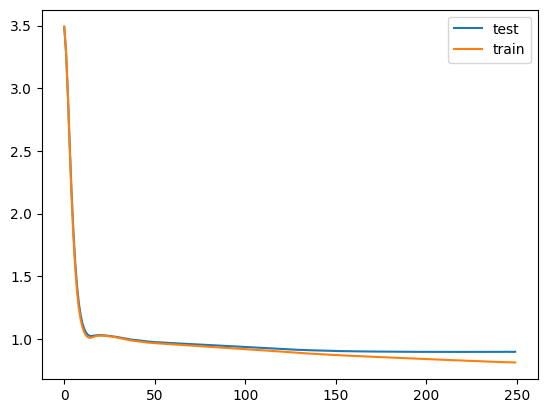

In [32]:
print(model.rmse_test_hist)
print(model.rmse_train_hist)
plt.plot(model.rmse_test_hist, label="test")
plt.plot(model.rmse_train_hist, label="train")
plt.title()
plt.legend()

## Result analysis

In [2]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [34]:
!python generate.py --name ./dataset/ratings_train.npy

Ratings loading...
Ratings Loaded.
Epoch [1/130], Loss: 0.011266
Epoch [2/130], Loss: 0.010260
Epoch [3/130], Loss: 0.009457
Epoch [4/130], Loss: 0.008800
Epoch [5/130], Loss: 0.008250
Epoch [6/130], Loss: 0.007777
Epoch [7/130], Loss: 0.007372
Epoch [8/130], Loss: 0.007034
Epoch [9/130], Loss: 0.006761
Epoch [10/130], Loss: 0.006552
Epoch [11/130], Loss: 0.006406
Epoch [12/130], Loss: 0.006314
Epoch [13/130], Loss: 0.006267
Epoch [14/130], Loss: 0.006253
Epoch [15/130], Loss: 0.006261
Epoch [16/130], Loss: 0.006280
Epoch [17/130], Loss: 0.006300
Epoch [18/130], Loss: 0.006314
Epoch [19/130], Loss: 0.006323
Epoch [20/130], Loss: 0.006326
Epoch [21/130], Loss: 0.006323
Epoch [22/130], Loss: 0.006315
Epoch [23/130], Loss: 0.006305
Epoch [24/130], Loss: 0.006293
Epoch [25/130], Loss: 0.006281
Epoch [26/130], Loss: 0.006271
Epoch [27/130], Loss: 0.006261
Epoch [28/130], Loss: 0.006254
Epoch [29/130], Loss: 0.006248
Epoch [30/130], Loss: 0.006244
Epoch [31/130], Loss: 0.006241
Epoch [32/130

In [4]:
def plot_cm(targets, predictions, model=None, title='Confusion Matrix'):  
    predictions = predictions[targets!=0]
    targets = targets[targets!=0]
    predictions_strings  = [str(prediction) for prediction in predictions]
    targets_strings  = [str(target) for target in targets]
    # Compute the confusion matrix
    cm = confusion_matrix(targets_strings, predictions_strings)
    
    # Display the confusion matrix as a heatmap
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    if (model is not None):
        plt.title(f"Confusion Matrix, num_epochs={model.num_epochs}, encoded_dim='{model.encoded_dim}'")
    else: 
        plt.title(title)
    
    plt.colorbar()
    
    classes = ['0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5']  # Replace with your class labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [5]:
def RMSE(targets, predictions):
    predictions = predictions[targets!=0]
    targets = targets[targets!=0]
    # Calculate the squared differences between predictions and targets
    squared_errors = (predictions - targets) ** 2

    # Calculate the mean of squared errors
    mean_squared_error = squared_errors.mean()

    # Calculate the square root to get RMSE
    return np.sqrt(mean_squared_error)

0.8913098181744525


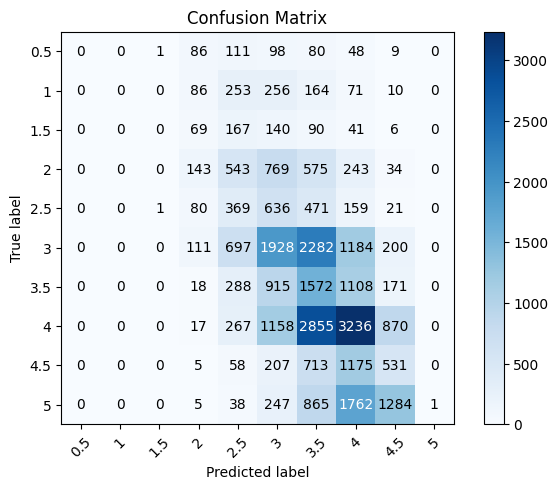

In [37]:
"""
    Use thise cell after running generate.py and assign the used file to calculate the train rmse.

    To have the test RMSE use the test file.
"""

targets = np.load('./dataset/ratings_test.npy')
targets[np.isnan(targets)] = 0

predictions = np.load('output.npy')
rmse_value = RMSE(targets, predictions) 

print(rmse_value)
plot_cm(targets, predictions)


Epoch [1/250], Loss: 498.280762
Epoch [2/250], Loss: 496.675812
Epoch [3/250], Loss: 495.318542
Epoch [4/250], Loss: 494.133026
Epoch [5/250], Loss: 493.331635
Epoch [6/250], Loss: 493.019348
Epoch [7/250], Loss: 493.442963
Epoch [8/250], Loss: 494.844147
Epoch [9/250], Loss: 497.432678
Epoch [10/250], Loss: 501.331116
Epoch [11/250], Loss: 506.423584
Epoch [12/250], Loss: 512.487488
Epoch [13/250], Loss: 519.126709
Epoch [14/250], Loss: 525.938416
Epoch [15/250], Loss: 532.633179
Epoch [16/250], Loss: 538.984436
Epoch [17/250], Loss: 544.827026
Epoch [18/250], Loss: 550.110596
Epoch [19/250], Loss: 554.817078
Epoch [20/250], Loss: 558.937866
Epoch [21/250], Loss: 562.475708
Epoch [22/250], Loss: 565.460083
Epoch [23/250], Loss: 567.959595
Epoch [24/250], Loss: 570.009766
Epoch [25/250], Loss: 571.652588
Epoch [26/250], Loss: 572.938782
Epoch [27/250], Loss: 573.921997
Epoch [28/250], Loss: 574.653198
Epoch [29/250], Loss: 575.171265
Epoch [30/250], Loss: 575.517578
Epoch [31/250], Los

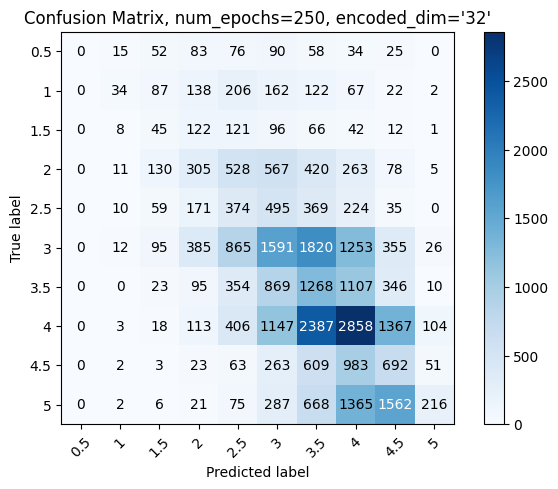

[1.922390341758728, 1.7601760625839233, 1.605979323387146, 1.4681147336959839, 1.3470324277877808, 1.2432513236999512, 1.1614216566085815, 1.1028951406478882, 1.0660933256149292, 1.0472259521484375, 1.039905071258545, 1.0377240180969238, 1.036218523979187, 1.0343267917633057, 1.0314627885818481, 1.0283806324005127, 1.0258623361587524, 1.0233944654464722, 1.0210758447647095, 1.0187417268753052, 1.0161608457565308, 1.0129103660583496, 1.009055256843567, 1.0048373937606812, 1.0005253553390503, 0.9963845610618591, 0.9927350282669067, 0.9896768927574158, 0.9870269298553467, 0.9845877289772034, 0.9823632836341858, 0.9802815318107605, 0.9782558679580688, 0.976296603679657, 0.9743672013282776, 0.9725055694580078, 0.9706485271453857, 0.968843400478363, 0.9670773148536682, 0.965305745601654, 0.9635103940963745, 0.9617025256156921, 0.9598191976547241, 0.9578957557678223, 0.9559183120727539, 0.953886866569519, 0.9518032670021057, 0.9497159719467163, 0.9476536512374878, 0.945667564868927, 0.9437414

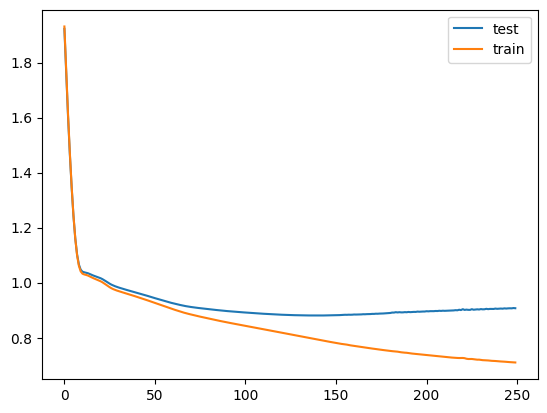

In [10]:
train_set = np.load('./dataset/ratings_train.npy')

train_set[np.isnan(train_set)] = 0
train_set = train_set/np.max(train_set)

test_set = np.load('./dataset/ratings_test.npy')
test_set[np.isnan(test_set)] = 0
encoded_dim = 32
input_size = train_set.shape 
hidden_size_row = 16
hidden_size_col = 64
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col, encoded_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
deepMF.train_model(model, optimizer, torch.FloatTensor(train_set), num_epochs=250, lambda_=10, mu_=10, test_data=test_set)
predicted, _, _ = model(torch.FloatTensor(train_set), torch.FloatTensor(train_set).T) 

targets = np.load('./dataset/ratings_test.npy')
targets[np.isnan(targets)] = 0

predictions = model.numpy_and_round(predicted)
rmse_value = RMSE(targets, predictions) 


plot_cm(targets, predictions, model)
print(model.rmse_test_hist)
print(model.rmse_train_hist)
plt.plot(model.rmse_test_hist, label="test")
plt.plot(model.rmse_train_hist, label="train")
print(print(np.min(model.rmse_test_hist)))
plt.legend()
correct_predictions = np.sum(targets[targets!=0] == predictions[targets!=0])
total_predictions = len(targets[targets!=0])

accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy * 100:.2f}%")



# PCA 

### Just for analysis


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [41]:
output = np.load('output.npy')
non_normalized_train_data = np.load('./dataset/ratings_train.npy')
non_normalized_train_data[np.isnan(non_normalized_train_data)] = 0
rmse_per_user = []
for line_output, line_test in zip(output, non_normalized_train_data):
    predictions = line_output[line_test!=0]
    targets = line_test[line_test!=0]
    # Calculate the squared differences between predictions and targets
    squared_errors = (predictions - targets) ** 2

    # Calculate the mean of squared errors
    mean_squared_error = squared_errors.mean()

    # Calculate the square root to get RMSE
    rmse_value = np.sqrt(mean_squared_error)
    rmse_per_user.append(rmse_value)
rmse_per_user = np.array(rmse_per_user)
print(rmse_per_user)

[0.83074716 0.74402381 2.39390251 1.21449578 0.747545   0.89172906
 1.21543109 0.88975652 1.03279556 1.08347268 0.74833148 1.0856203
 0.78173596 1.06800047 1.17260394 0.6413192  0.54906337 0.49363031
 0.8660254  1.02273018 1.01323213 1.54536659 0.58123819 0.43643578
 0.5        0.70710678 1.20585307 0.82388049 0.42257713 0.79056942
 1.01036297 0.67783439 0.96076892 1.29269201 0.82158384 1.
 1.27475488 1.05220856 0.89611958 0.84834956 1.02120377 0.95321597
 0.84016805 0.93541435 0.8503393  0.62678317 1.07529066 0.64549722
 0.44095855 0.70896515 1.04482853 0.71278644 1.29903811 0.62360956
 1.78885438 0.59603956 0.91571921 0.8819171  0.89871703 0.73192505
 0.79930525 0.72796262 0.9009982  0.62834471 0.53452248 0.59702231
 0.74402381 0.9314563  0.72648316 0.56144224 1.07043605 0.36927447
 0.98280674 0.72547625 1.26491106 1.40967354 1.68325082 0.96362411
 0.6751906  0.50507627 1.05220856 0.9686649  1.06066017 0.67566392
 1.26655701 0.56879646 0.70710678 0.42491829 1.18668776 0.82717019
 0.8

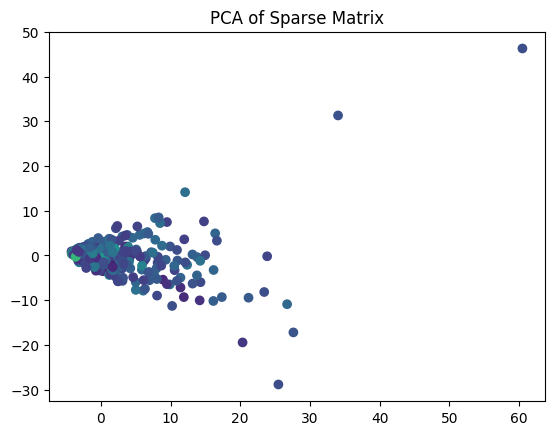

In [42]:
# Generate a random sparse matrix
X = non_normalized_train_data = np.load('./dataset/ratings_train.npy')
X[np.isnan(X)] = 0

n_samples = X.shape[0]
n_features = X.shape[1]

# Perform PCA
n_components = 2  # Number of components to retain
pca = PCA(n_components=n_components)
X_r = pca.fit_transform(X)

# Plot the results
fig = plt.figure()
plt.scatter(X_r[:, 0], X_r[:, 1], c=rmse_per_user)
plt.title('PCA of Sparse Matrix')
plt.show()


Epoch [1/250], Loss: 0.006982
Epoch [2/250], Loss: 0.006704
Epoch [3/250], Loss: 0.006504
Epoch [4/250], Loss: 0.006371
Epoch [5/250], Loss: 0.006290
Epoch [6/250], Loss: 0.006252
Epoch [7/250], Loss: 0.006246
Epoch [8/250], Loss: 0.006253
Epoch [9/250], Loss: 0.006256
Epoch [10/250], Loss: 0.006249
Epoch [11/250], Loss: 0.006235
Epoch [12/250], Loss: 0.006222
Epoch [13/250], Loss: 0.006213
Epoch [14/250], Loss: 0.006206
Epoch [15/250], Loss: 0.006198
Epoch [16/250], Loss: 0.006188
Epoch [17/250], Loss: 0.006177
Epoch [18/250], Loss: 0.006166
Epoch [19/250], Loss: 0.006155
Epoch [20/250], Loss: 0.006145
Epoch [21/250], Loss: 0.006137
Epoch [22/250], Loss: 0.006129
Epoch [23/250], Loss: 0.006122
Epoch [24/250], Loss: 0.006114
Epoch [25/250], Loss: 0.006107
Epoch [26/250], Loss: 0.006100
Epoch [27/250], Loss: 0.006095
Epoch [28/250], Loss: 0.006090
Epoch [29/250], Loss: 0.006084
Epoch [30/250], Loss: 0.006078
Epoch [31/250], Loss: 0.006073
Epoch [32/250], Loss: 0.006068
Epoch [33/250], L

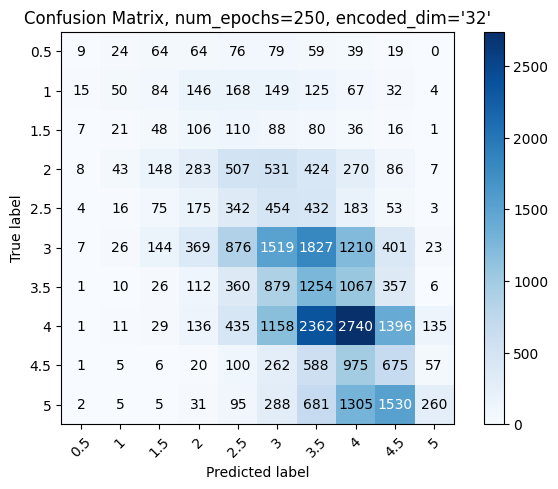

In [33]:
train_set = np.load('./dataset/ratings_train.npy')

train_set[np.isnan(train_set)] = 0
train_set = train_set/np.max(train_set)
test_set = np.load('./dataset/ratings_test.npy')
test_set[np.isnan(test_set)] = 0
encoded_dim = 32
input_size = train_set.shape 
hidden_size_row = 16
hidden_size_col = 64
model = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col, encoded_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
deepMF.train_model(model, optimizer, torch.FloatTensor(train_set), num_epochs=250, lambda_=0, mu_=0, test_data=test_set)
predicted, _, _ = model(torch.FloatTensor(train_set), torch.FloatTensor(train_set).T) 
targets = test_set
targets[np.isnan(targets)] = 0

predictions = model.numpy_and_round(predicted)
rmse_value = RMSE(targets, predictions) 

print(rmse_value)
plot_cm(targets, predictions, model)


Epoch [1/250], Loss: 433.809540
Epoch [2/250], Loss: 423.895508
Epoch [3/250], Loss: 538.203430
Epoch [4/250], Loss: 792.714966
Epoch [5/250], Loss: 1077.208008
Epoch [6/250], Loss: 1412.122070
Epoch [7/250], Loss: 1754.154663
Epoch [8/250], Loss: 2070.643799
Epoch [9/250], Loss: 2378.585449
Epoch [10/250], Loss: 2689.304688
Epoch [11/250], Loss: 3002.397461
Epoch [12/250], Loss: 3305.750244
Epoch [13/250], Loss: 3589.663330
Epoch [14/250], Loss: 3848.328857
Epoch [15/250], Loss: 4084.285400
Epoch [16/250], Loss: 4302.078613
Epoch [17/250], Loss: 4499.706055
Epoch [18/250], Loss: 4674.263672
Epoch [19/250], Loss: 4827.696289
Epoch [20/250], Loss: 4963.145020
Epoch [21/250], Loss: 5082.724609
Epoch [22/250], Loss: 5189.175781
Epoch [23/250], Loss: 5282.756348
Epoch [24/250], Loss: 5358.777344
Epoch [25/250], Loss: 5417.003906
Epoch [26/250], Loss: 5464.734863
Epoch [27/250], Loss: 5507.740723
Epoch [28/250], Loss: 5548.077148
Epoch [29/250], Loss: 5585.037109
Epoch [30/250], Loss: 5616.

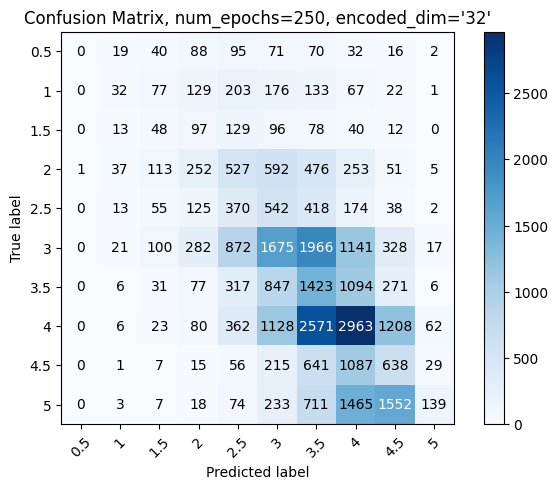

[2.5670385360717773, 1.821210265159607, 1.077990174293518, 1.0817610025405884, 1.0601768493652344, 1.055091142654419, 1.062362790107727, 1.0347844362258911, 1.031577706336975, 1.0322531461715698, 1.014901041984558, 1.010303258895874, 1.0107057094573975, 1.0045130252838135, 0.9996225237846375, 1.0017567873001099, 1.0009428262710571, 0.9932785630226135, 0.987446129322052, 0.986029863357544, 0.9822284579277039, 0.9776363968849182, 0.9773066639900208, 0.9752234816551208, 0.9679139256477356, 0.962154746055603, 0.9579265713691711, 0.9526901841163635, 0.9510385394096375, 0.9469090700149536, 0.9430893063545227, 0.9408480525016785, 0.9362270832061768, 0.9343380331993103, 0.9300849437713623, 0.9276008009910583, 0.9245888590812683, 0.9224855303764343, 0.9204999804496765, 0.9164948463439941, 0.913941502571106, 0.9107729196548462, 0.9090008735656738, 0.9050737619400024, 0.9028874039649963, 0.9004979729652405, 0.8993667960166931, 0.8970239162445068, 0.8959857225418091, 0.8949353098869324, 0.89394742

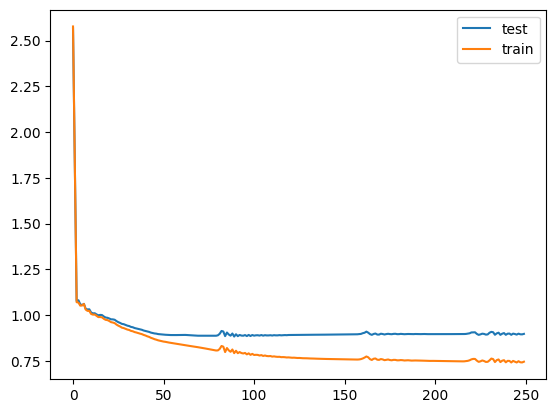

In [38]:
train_set = np.load('./dataset/ratings_train.npy')

train_set[np.isnan(train_set)] = 0
train_set = train_set/np.max(train_set)

test_set = np.load('./dataset/ratings_test.npy')
test_set[np.isnan(test_set)] = 0
encoded_dim = 32
input_size = train_set.shape 
hidden_size_row = 16
hidden_size_col = 64
model_reg = deepMF.ParallelLayersModel(input_size, hidden_size_row, hidden_size_col, encoded_dim)
optimizer = torch.optim.AdamW(model_reg.parameters(), lr=0.001, weight_decay=0.0001)
deepMF.train_model(model_reg, optimizer, torch.FloatTensor(train_set), num_epochs=250, lambda_=10, mu_=10, test_data=test_set)
predicted, _, _ = model_reg(torch.FloatTensor(train_set), torch.FloatTensor(train_set).T) 

targets = np.load('./dataset/ratings_test.npy')
targets[np.isnan(targets)] = 0

predictions = model_reg.numpy_and_round(predicted)
rmse_value = RMSE(targets, predictions) 


plot_cm(targets, predictions, model_reg)
print(model_reg.rmse_test_hist)
print(model_reg.rmse_train_hist)
plt.plot(model_reg.rmse_test_hist, label="test")
plt.plot(model_reg.rmse_train_hist, label="train")
print(print(np.min(model_reg.rmse_test_hist)))
plt.legend()
correct_predictions = np.sum(targets[targets!=0] == predictions[targets!=0])
total_predictions = len(targets[targets!=0])

accuracy = correct_predictions / total_predictions

print(f"Accuracy: {accuracy * 100:.2f}%")


Text(0.5, 1.0, 'RMSE comparison')

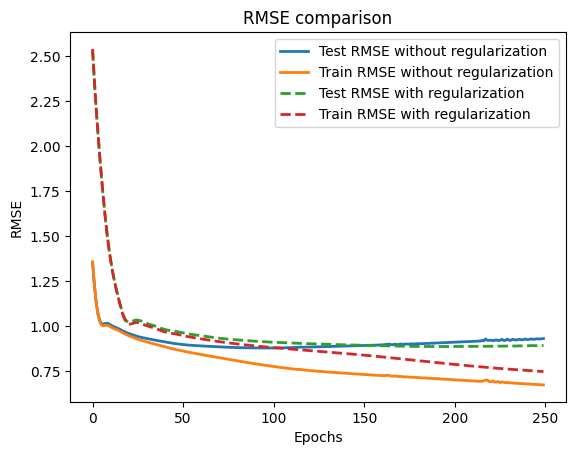

In [36]:
#print(model.rmse_test_hist)
#print(model.rmse_train_hist)
plt.plot(model.rmse_test_hist, label="Test RMSE without regularization", linestyle='-', linewidth=2)
plt.plot(model.rmse_train_hist, label="Train RMSE without regularization", linestyle='-', linewidth=2)
plt.plot(model_reg.rmse_test_hist, label="Test RMSE with regularization", linestyle='--', linewidth=2)
plt.plot(model_reg.rmse_train_hist, label="Train RMSE with regularization", linestyle='--', linewidth=2)
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.title('RMSE comparison')